<h1> This code perform inference on single cell based on its center coordinates </h1>

In [2]:
import napari
viewer = napari.Viewer()

In [3]:
import numpy as np
from TCFile import TCFile
import matplotlib.pyplot as plt
import utils

path = r"C:\rkka_Projects\cell_death_v2\Data\8. A549 cell death(20250404)\250404.153021.A549_death_01_TNFa.001.Group1.A2.T001P01.TCF"
file = TCFile(path, '2DMIP')
image = np.array([f for f in file])
viewer.add_image(image)

<Image layer 'image' at 0x13165f9edb0>

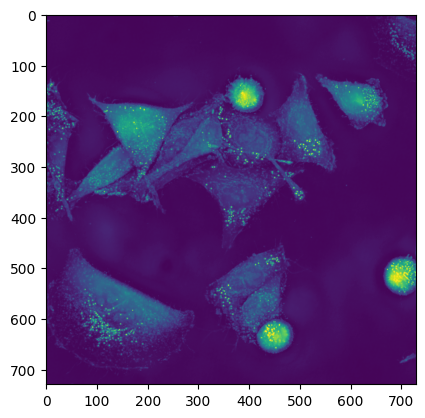

In [4]:
slice = utils.image_normalization(image[20], min=1.33, max=1.40)
plt.imshow(slice)

In [5]:
import numpy as np
import utils
from TCFile import TCFile
from PIL import Image

path = r"C:\rkka_Projects\cell_death_v2\Data\8. A549 cell death(20250404)\250404.153021.A549_death_01_TNFa.001.Group1.A2.T001P03.TCF"
file = TCFile(path, '2DMIP')
image = np.array([utils.resize_tomogram_mip(f, data_resolution=file.data_resolution, target_resolution=0.1632, mode='mip') for f in file])
# image = np.array([f for f in file])
viewer.add_image(image)

<Image layer 'image [1]' at 0x131845eca40>

In [6]:
centers = [
(96, 96),
(177, 202),
(288, 272),
(433, 324),
(96, 778),
(488, 731),
(594, 618),
(581, 100)
]

In [15]:
from PIL import Image
import torch
import utils
from torchvision import models
from TCFile import TCFile
import numpy as np
from tqdm import tqdm

model_path = r"C:\rkka_Projects\cell_death_v2\trained_models\test_5_classes_22.032991_0.9728_sota.pth"
path = r"C:\rkka_Projects\cell_death_v2\Data\9. A549_FasL(20250410)\250409.170229.A549_FasL_01.025.Group5.C4.T025P04.TCF"
# Load Model
model = models.resnet101(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 5)
)
model.load_state_dict(torch.load(model_path))
model = model.cuda()

transform = models.ResNet101_Weights.IMAGENET1K_V2.transforms()
file = TCFile(path, '2DMIP')

offset = [(0, 0), (-16,-16), (-16, 16), (16, -16), (16, 16)]

# offset = [(0, 0)]
total_probabilities = []
for time in tqdm(range(1)):
    # center = necroptosis_2[time]
    time = 0
    total = []
    for center in centers:
        mid_probabilities = []
        
        f = utils.resize_tomogram_mip(file[time], data_resolution=file.data_resolution, target_resolution=0.1632, mode='mip')
        f = utils.image_normalization(f, min=1.33, max=1.40)
        
        for off in offset:
            a = f[center[0]-80+off[0]:center[0]+80+off[0], center[1]-80+off[1]:center[1]+80+off[1]]
            a = torch.from_numpy(a)

            outputs = []
            labels = []
            with torch.no_grad():
                model = model.eval()
                
                i = a.unsqueeze(0).repeat(3,1,1).float()
                i = transform(i)
                output = model(i.unsqueeze(0).cuda())
                outputs.append(output)
                labels.append(int(torch.max(output, 1)[1].cpu().numpy()[0]))
                    
            # 확률 계산산
            import torch.nn.functional as F
            with torch.no_grad():
                # output = torch.from_numpy(wanted_probabilities[0])
                # Apply softmax to get probabilities
                probabilities = []
                for output in outputs:
                    probs = F.softmax(output.cpu(), dim=1)  # shape: [1, 5]
                    # If you want it as a simple list or tensor
                    probs = probs.squeeze()  # shape: [5]
                    probs = probs.numpy()
                    probabilities.append(probs)
                    
            mid_probabilities.append(probabilities[0])
        
        mid_probabilities = np.array(mid_probabilities)
        mid_probabilities = np.mean(mid_probabilities, axis=0)
        mid_probabilities = mid_probabilities / np.sum(mid_probabilities)
        total_probabilities.append(mid_probabilities)
        mid_index = np.argmax(mid_probabilities)
        total.append(mid_index)
        

total

c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


[np.int64(4),
 np.int64(4),
 np.int64(4),
 np.int64(4),
 np.int64(4),
 np.int64(0),
 np.int64(0),
 np.int64(4)]

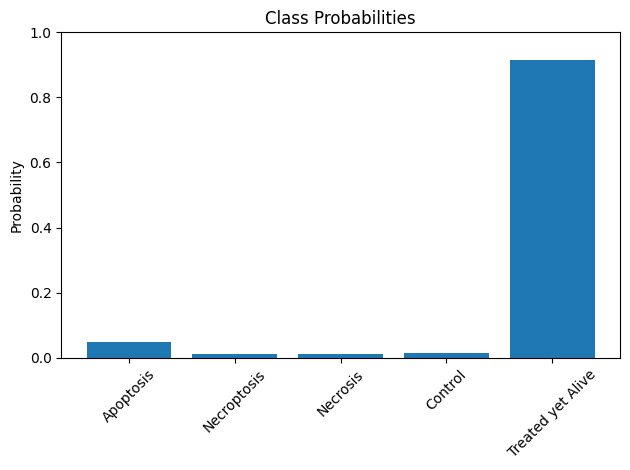

In [18]:
import matplotlib.pyplot as plt

# Assuming you already have probs as a numpy array
class_names = ['Apoptosis', 'Necroptosis', 'Necrosis', 'Control', 'Treated yet Alive']  # change these to your actual class names

plt.bar(range(len(total_probabilities[0])), total_probabilities[0])
plt.xticks(range(len(total_probabilities[0])), class_names, rotation=45)
plt.ylabel('Probability')
plt.title('Class Probabilities')
plt.tight_layout()
plt.ylim(0,1)
# plt.savefig(f'figures/figure_supplementary/cell_c4p4_timelapse_1_{0}_prop.svg', format='svg')
plt.show()